# Text Classification with BERT

Transformers have profoundly impacted Natural Language Processing (NLP) tasks by introducing a groundbreaking architecture that excels in comprehensively capturing contextual information. Their unique self-attention mechanisms enable a holistic analysis of input sequences, overcoming the constraints of conventional sequential models. This transformative breakthrough has resulted in notable progress in machine translation, sentiment analysis, and language comprehension. Exemplified by models like BERT and GPT, the Transformer architecture stands as a fundamental cornerstone in NLP, fostering innovation and pushing the frontiers of language understanding across a spectrum of applications and industries.

BERT, or Bidirectional Encoder Representations from Transformers, has emerged as a pivotal milestone in Natural Language Processing (NLP). Introduced by Google, BERT revolutionizes language understanding by considering context from both preceding and succeeding words in a sentence. This bidirectional approach enables BERT to grasp intricate nuances and dependencies, leading to superior performance in various NLP tasks. Its pre-training on vast amounts of text data equips it with a deep understanding of language structures, making BERT a transformative force in enhancing accuracy and contextual relevance across diverse applications.

<div class="alert alert-info">
    <h4>In this Project</h4>
    <ul>
        <li>Classification of Tweets into 6 different forms of Cyberbullying</li>
        <li>Using BERT base model and fine tuning it to our dataset</li>
    </ul>
</div>

## Setting Up

In [1]:
import os
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import Union, List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 14

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_data(dataFile:str) -> Union[List, List]:
    df = pd.read_csv(dataFile)
    texts = df['tweet_text'].tolist()
    labels = df['cyberbullying_type'].tolist()
    return texts, labels

In [4]:
dataFile = '/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv'
texts, labels = load_data(dataFile)

In [5]:
len(texts), len(labels)

(47692, 47692)

In [6]:
labEncoder = LabelEncoder()
labEncoder.fit(labels)
labelsEncoded = labEncoder.transform(labels)

## Exploratory Data Analysis

In [7]:
df = pd.DataFrame({'text':texts, 'labels':labels})
df.head()

,text,labels
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


### Check Missing Values

In [8]:
any(df.isna().sum())

False

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47692 non-null  object
 1   labels  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


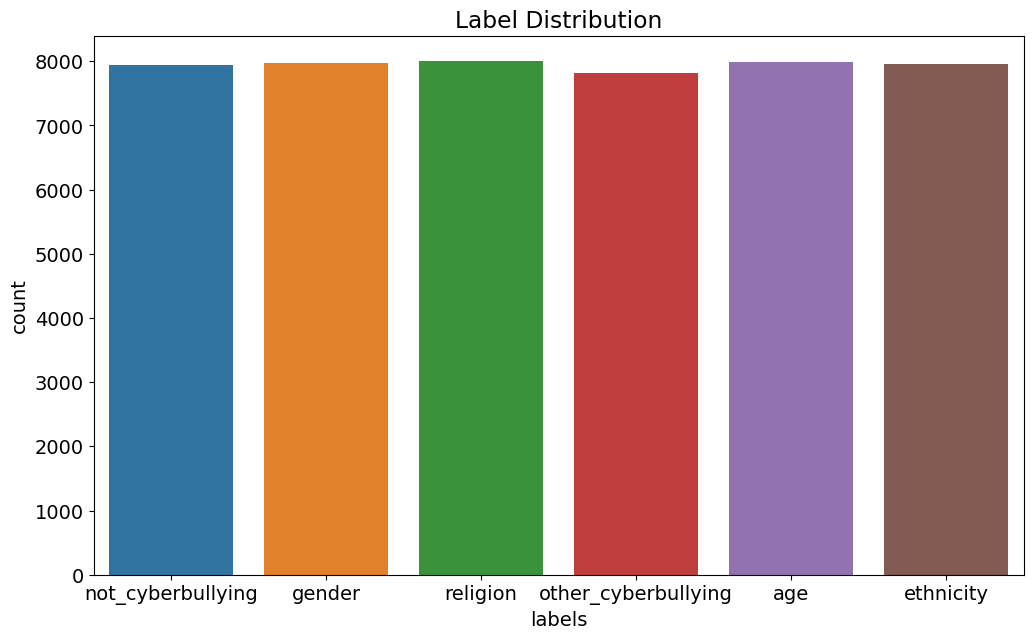

In [10]:
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='labels')
plt.title("Label Distribution")
plt.show()

### Tweet Length

In [11]:
df['length'] = df['text'].str.len()

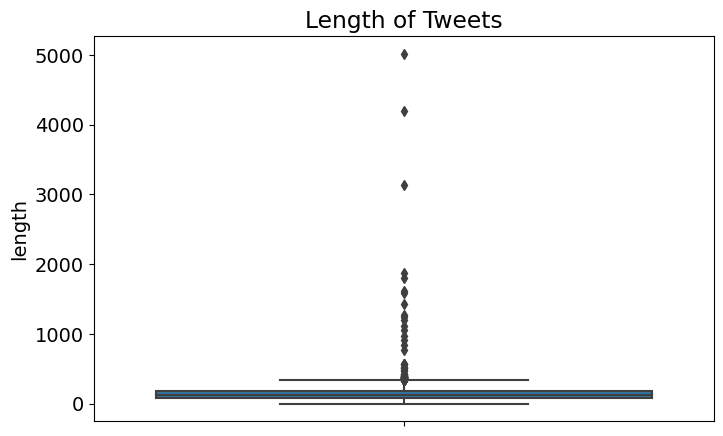

In [12]:
sns.boxplot(data=df, y='length')
plt.title("Length of Tweets")
plt.show()

### Word Count

In [13]:
def word_count(x):
    return len(x.split())

df['word_count'] = df['text'].apply(word_count)

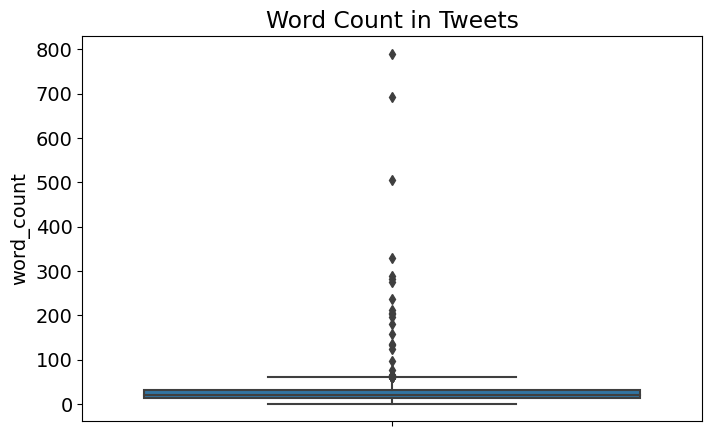

In [14]:
sns.boxplot(data=df, y='word_count')
plt.title("Word Count in Tweets")
plt.show()

## Dataset Building

In [15]:
class TextClassificationDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

## Model Building

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/0*ViwaI3Vvbnd-CJSQ.png" />

<h4><strong>Architecture of BERT</strong></h4>
<p>
BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task. Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary.

As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).
</p>

In [16]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

## Utility Functions

In [17]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [18]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = list()
    actual = list()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual.extend(labels.cpu().tolist())
    return accuracy_score(y_true=actual, y_pred=predictions), classification_report(y_true=actual, y_pred=predictions)

In [35]:
def predict_class(text, model, tokenizer, device, classes, max_length=128):
    model.eval()
    print("Model:",model)
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return classes[preds.item()]

## Define Model Parameters

In [20]:
bert_model_name = 'bert-base-uncased'
num_classes = 6
max_length = 128
batch_size = 32
num_epochs = 5
learning_rate = 2e-5

## Splitting Dataset

In [21]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labelsEncoded, test_size=0.2, random_state=42)
len(train_texts), len(val_texts), len(train_labels), len(val_labels)

(38153, 9539, 38153, 9539)

In [22]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer=tokenizer, max_length=max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer=tokenizer, max_length=max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Setting up the Model

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [24]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

## Model Training

In [25]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/5
Validation Accuracy: 0.8531
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1603
           1       0.99      0.97      0.98      1603
           2       0.89      0.87      0.88      1531
           3       0.81      0.43      0.56      1624
           4       0.61      0.91      0.73      1612
           5       0.94      0.98      0.96      1566

    accuracy                           0.85      9539
   macro avg       0.87      0.85      0.85      9539
weighted avg       0.87      0.85      0.85      9539

Epoch 2/5
Validation Accuracy: 0.8661
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1603
           1       0.99      0.97      0.98      1603
           2       0.88      0.88      0.88      1531
           3       0.71      0.61      0.66      1624
           4       0.69      0.79      0.74      1612
           5       0.94      0.97      0.96      1566

 

In [28]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "Cyber.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)


## Model Evaluation

In [33]:
classes = labEncoder.classes_.tolist()
print(classes)

['age', 'ethnicity', 'gender', 'not_cyberbullying', 'other_cyberbullying', 'religion']


In [27]:
for _ in range(10):
    random_idx = random.randint(0, len(val_texts))
    text = val_texts[random_idx]
    label = classes[val_labels[random_idx]]
    pred = predict_class(text, model, tokenizer, device, classes)

    print("=============================================")
    print(f"Text:\n{text}")
    print(f"Actual: {label}\tPredicted: {pred}")
    print("=============================================")

Text:
..all the powerful jokes about rape,race,the disabled, gays, are the ones that make anyone but the victim the butt of the joke....
Actual: gender	Predicted: gender
Text:
She had a bookbag over her head and everything and yall talkin about rape and sexual assault gtfoh sensitive people ruin EVERYTHING. Niggas is too soft nowadays yall the reason they wont bring the office back now, because 1 gay joke would piss yall off and get the show cancelled
Actual: gender	Predicted: gender
Text:
RT @brian_day15: I swear, I'm not sexist, but I honestly just cannot stand the woman college football announcer on ESPN2
Actual: gender	Predicted: gender
Text:
Rape jokes aren't funny. They're inappropriate and offensive. So is using the word "gay" and "retarded" in negative connotation. #annoyed
Actual: gender	Predicted: gender
Text:
Carry on man you serve the very purpose of defending Ismalist Terrorism in the name of Jihad . Things which terrorist country like Pakistan practices in my country is n

In [39]:
torch.save(model, 'Cyber_new_model.pkl')


In [36]:
# load model from pickle file
with open(model_pkl_file, 'rb') as file:  
    model_1 = pickle.load(file)

# evaluate model 
#text = "She had a bookbag over her head and everything and yall talkin about rape and sexual assault gtfoh sensitive people ruin EVERYTHING. Niggas is too soft nowadays yall the reason they wont bring the office back now, because 1 gay joke would piss yall off and get the show cancelled"
text = "Try throwing ur dab in first then hitting it w the torch till it starts bubbling. I've switched becuase i hate accdmidently taking a hit one lol"
y_predict = predict_class(text,model_1,tokenizer,device,classes)

# check results
print(y_predict) 

Model: BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

<div class="alert alert-success">
<h4>Conclusion</h4>
    <p>
    In conclusion, BERT is a powerful advancement in the field of NLP. With minimal preprocessing, setup and time, the model achieves great results,
    and is able to perform well across multiple classes. This is a rather basic usage of the architecture, it's capabalities extend to several other use cases
    and applications. There are several other models like BERT, based on the Transformer architecture that create a powerful ecosystem of these models.
    </p>
</div>